In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math

import itertools
import re

from collections import Counter, defaultdict
import umap

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

In [4]:
def generate_until_period(input_text, model, tokenizer, n, max_length=50):

    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)

    # Generate tokens until a period is encountered
    generated_ids = input_ids
    prob = []
    while True:
        logits = model(generated_ids).logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)

        # Indices of n highest logits
        top_indices = torch.topk(logits, n, dim=-1).indices.squeeze(dim=0)
        
        # Normalize probabilities of top n tokens
        top_probs = probs[0, top_indices]
        top_probs = top_probs / top_probs.sum()

        # Sample token from top n token distribution
        next_token_id = torch.multinomial(top_probs, num_samples=1).item()
        prob.append(top_probs[next_token_id].item())
        generated_ids = torch.cat([generated_ids, torch.tensor([[top_indices[next_token_id]]], device=device)], dim=-1)
        next_token = tokenizer.decode(top_indices[next_token_id].item())
        
        # Check if the token ends with sentence-ending punctuation
        if next_token[-1] in ['.', '!', '?']:
            break
        
        if generated_ids.shape[1] > max_length:
            break
    
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text, prob

def extract_unique_words(sentences):
    words = set()
    for sentence in sentences:
        # Remove periods and split into words, using a regular expression
        sentence_words = re.findall(r'\b\w+\b', sentence.lower())
        words.update(sentence_words)
    return words

def entropy(p, base=2):
    """Compute Shannon entropy of distribution p (list of floats summing to 1)."""
    log_fn = math.log if base == math.e else (lambda x: math.log(x, base))
    H = 0.0
    for pi in p:
        if pi > 0:
            H -= pi * log_fn(pi)
    return H

def mutual_information(samples, keyword1, keyword2):

    num_traj = len(samples)

    count1 = 0
    count2 = 0

    count_joint1 = 0
    count_joint2 = 0
    count_joint3 = 0
    count_joint4 = 0


    for sen in samples:
        if keyword1 in sen:
            count1 += 1
        
        if keyword2 in sen:
            count2 += 1

        if keyword1 in sen and keyword2 in sen:
            count_joint1 += 1
        
        if keyword1 not in sen and keyword2 not in sen:
            count_joint2 += 1

        if keyword1 in sen and keyword2 not in sen:
            count_joint3 += 1
        
        if keyword1 not in sen and keyword2 in sen:
            count_joint4 += 1


    prob1 = count1 / num_traj
    prob2 = count2 / num_traj
    prob1and2 = count_joint1 / num_traj
    prob1not2 = count_joint3 / num_traj
    prob2not1 = count_joint4 / num_traj
    probno1no2 = count_joint2 / num_traj

    joint_prob = [prob1and2, prob1not2, prob2not1, probno1no2]
    total_sum = sum(joint_prob)

    # Normalize the list by dividing each element by the total sum
    normalized_joint_prob = [prob / total_sum for prob in joint_prob]

    proba = [prob1, 1-prob1]
    total_sum = sum(proba)
    normalized_proba = [prob / total_sum for prob in proba]

    probb = [prob2, 1-prob2]
    total_sum = sum(probb)
    normalized_probb = [prob / total_sum for prob in probb]


    joint_entropy = entropy(normalized_joint_prob)
    h_a = entropy(normalized_proba)
    h_b = entropy(normalized_probb)

    mi = h_a + h_b - joint_entropy

    return mi, h_a, h_b, joint_entropy


In [10]:
# Load pre-trained Pythia model and tokenizer
model_name = "EleutherAI/pythia-410m-deduped"  # Adjust as necessary
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [11]:
input_text = "Biology is"
num_traj = 5000
n=5

gen_sens = []

p_vals = []

for i in range(num_traj):
    generated_text, p = generate_until_period(input_text, model, tokenizer, n)
    print(generated_text)
    val = np.prod(p)
    p_vals.append(val)
    gen_sens.append(generated_text)

Biology is a field of science that studies the evolution of life on Earth and the environment, as well as the evolution of the human mind.
Biology is the study of organisms and their interactions.
Biology is the science that describes the processes that occur within the human body.
Biology is the study of the physical, biological, chemical, and biological processes involved in life.
Biology is the science that deals with the world around us, but it’s more than just biology.
Biology is an important and important subject for all the scientists and students.
Biology is an important part of the education of the student and it is very important that we have the correct information and that it is presented clearly.
Biology is a fascinating subject.
Biology is a very important subject, which has been the subject of a lot of research.
Biology is the study of the biological processes that regulate life.
Biology is an important part of the human experience.
Biology is the study of the body's fun

KeyboardInterrupt: 

In [12]:

unique_words = extract_unique_words(gen_sens)
print(len(unique_words))

all_words = []
for sentence in gen_sens:
    words = re.findall(r'\b\w+\b', sentence.lower())
    all_words.extend(words)

word_counts = Counter(all_words)
words_more_than_100 = [word for word, count in word_counts.items() if count > 100]
print(words_more_than_100)

1870
['biology', 'is', 'a', 'field', 'of', 'science', 'that', 'the', 'evolution', 'life', 'on', 'and', 'environment', 'as', 'human', 'study', 'organisms', 'their', 'processes', 'body', 'physical', 'biological', 'in', 'with', 'world', 'but', 'it', 's', 'an', 'important', 'subject', 'for', 'part', 'very', 'we', 'have', 'fascinating', 'which', 'has', 'been', 'research', 'by', 'our', 'to', 'its', 'most', 'scientific', 'best', 'way', 'learn', 'how', 'one', 'can', 'are', 'be', 'not', 'sciences', 'exciting', 'things', 'natural', 'living', 'interesting', 'i', 'great', 'also', 'about', 'only', 'development', 'art', 'understand']


In [14]:
miis = []
mii_vals = []
unique_words = extract_unique_words(words_more_than_100)



for w1, w2 in itertools.combinations(unique_words, 2):

    mi, h_a, h_b, h_joint = mutual_information(gen_sens, w1, w2)
    miis.append(((w1,w2),mi))
    mii_vals.append(mi)
sorted_miis = sorted(miis, key=lambda x: x[1], reverse=True) 


Text(0.5, 1.0, '410m Model: Biology is...')

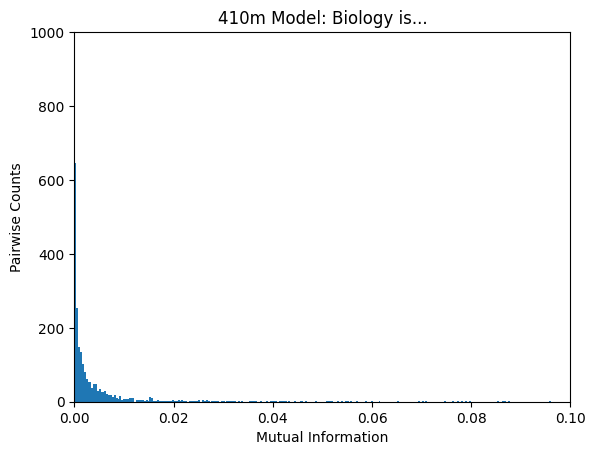

In [16]:
nz_vals = []

for val in mii_vals:
    if val < 1e-8:
        pass
    else:
        nz_vals.append(val)

plt.hist(nz_vals, bins=1000)
plt.xlim(0,0.1)
plt.xlabel('Mutual Information')
plt.ylabel('Pairwise Counts')
plt.ylim(0,1000)
plt.title('410m Model: Biology is...')